In [1]:
import sys
import json
import requests
import numpy as np
import pandas as pd
from swgoh_data_track import *
from datetime import datetime, timedelta
from swgoh_api import *
from swgoh_db import *
import sqlite3
from sqlite3 import Error
from matplotlib import pyplot as plt
import seaborn as sns
import time
plt.style.use('ggplot')
from collections import OrderedDict

Please note that the program expects to find the file ../CONFIGURE.json with the following format:
{
    "swgoh.help": {
        "username": "user",
        "password": "pass",
        "grant_type": "password",
        "client_id": "abc",
        "client_secret": "123"
    }
}


In [2]:
st='199163671 686185564 798654686 878757536 371974424 189786791 884385824 178147776 272627599 619687796 164117549 971123259 537146654 474263561 132712723 222428941 861625191 823638487 859553924 962934533 925247332 394714224 757213814 838136292 179943728 694145356 513743513 123528241 398153272 381239626 237821622 219356143 633221476'

In [19]:
co_arena=st.split()

In [5]:
def calculate_secondaries(player,stat,thresh):
    tr_d=dict(zip(thresh,[0]*len(thresh)))
    for char in player['roster']:
        for mod in char['mods']:
            for secondary_stat in mod['secondaryStat']:
                if secondary_stat['unitStat']==stat:
                    for tr_one in thresh:
                        if secondary_stat['value']>=tr_one: tr_d[tr_one]+=1
                    break
    return tr_d    

In [4]:
project= {'language': 'eng_us','allycodes':928428534,'enums':True}
one_payer=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

{'token_type': 'bearer', 'access_token': '0768c2b5a1cb713387b4b9270661e5ce190063b7', 'expires_in': 3600}
Logged in successfully


In [9]:
one_payer[0]['arena']['char']

{'rank': 25,
 'squad': [{'id': 'OG3vsJHfTMOXXXc98RWEYA',
   'defId': 'DARTHREVAN',
   'squadUnitType': 'UNITTYPELEADER'},
  {'id': 'BYTpGknkRmGNwVYVr1Vn2A',
   'defId': 'HK47',
   'squadUnitType': 'UNITTYPEDEFAULT'},
  {'id': '16Y6-RohQAG6WPbCgiXpzA',
   'defId': 'BASTILASHANDARK',
   'squadUnitType': 'UNITTYPEDEFAULT'},
  {'id': 'SgmC9DBYS3KOhPnbgadEDQ',
   'defId': 'DARTHMALAK',
   'squadUnitType': 'UNITTYPEDEFAULT'},
  {'id': 'T8C5HLR2RCypWWFKXtEklA',
   'defId': 'SITHTROOPER',
   'squadUnitType': 'UNITTYPEDEFAULT'}]}

In [21]:
project= {'language': 'eng_us','allycodes':928428534,'enums':True,'project':
          {'allyCode':1,'name':1,"updated":1,'arena':{'char':{'rank':1}}}}
one_payer=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
one_payer

{'token_type': 'bearer', 'access_token': '9894a17f8b6834f96ee540f5b259cb5b6c2e25d3', 'expires_in': 3600}
Logged in successfully


[{'allyCode': 928428534,
  'name': 'Lossberg',
  'arena': {'char': {'rank': 25}},
  'updated': 1559766201188}]

In [26]:
project= {'language': 'eng_us','allycodes':co_arena,'enums':True,'project':
          {'allyCode':1,'name':1,"updated":1,'arena':{'char':{'rank':1}}}}
co_shard=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
co_shard
for p in co_shard:
    p['arena']=p['arena']['char']['rank']
    p['updated']=datetime.fromtimestamp(p['updated']/1000)

{'token_type': 'bearer', 'access_token': '515d48ff84ab1a86bca86d2838fb16122dbf0b37', 'expires_in': 3600}
Logged in successfully


In [23]:
for p in co_shard:
    p['arena']=p['arena']['char']['rank']

In [31]:
df_co=pd.DataFrame(co_shard)

In [36]:
df_co['updated']#.dt.strftime('%H:%M:%S')

0    2019-06-05 20:40:58.982
1    2019-06-05 20:40:59.248
2    2019-06-05 20:40:59.317
3    2019-06-05 20:40:59.338
4    2019-06-05 20:40:59.298
5    2019-06-05 21:11:21.337
6    2019-06-05 20:40:58.503
7    2019-06-05 20:13:03.068
8    2019-06-05 20:41:02.043
9    2019-06-05 20:35:52.279
10   2019-06-05 20:40:58.798
11   2019-06-05 20:40:59.074
12   2019-06-05 20:40:58.287
13   2019-06-05 20:40:58.891
14   2019-06-05 22:18:50.879
15   2019-06-05 20:40:59.245
16   2019-06-05 20:40:58.971
17   2019-06-05 20:40:58.961
18   2019-06-05 20:14:03.422
19   2019-06-05 20:40:58.790
20   2019-06-05 20:40:58.027
21   2019-06-05 20:40:58.608
22   2019-06-05 20:40:58.468
23   2019-06-05 22:19:31.542
24   2019-06-05 20:40:58.890
25   2019-06-05 20:14:03.872
26   2019-06-05 20:40:59.027
27   2019-06-05 20:40:58.744
28   2019-06-05 20:40:58.791
29   2019-06-05 22:19:38.332
30   2019-06-05 20:40:58.361
31   2019-06-05 20:40:59.005
32   2019-06-05 20:40:59.079
Name: updated, dtype: datetime64[ns]

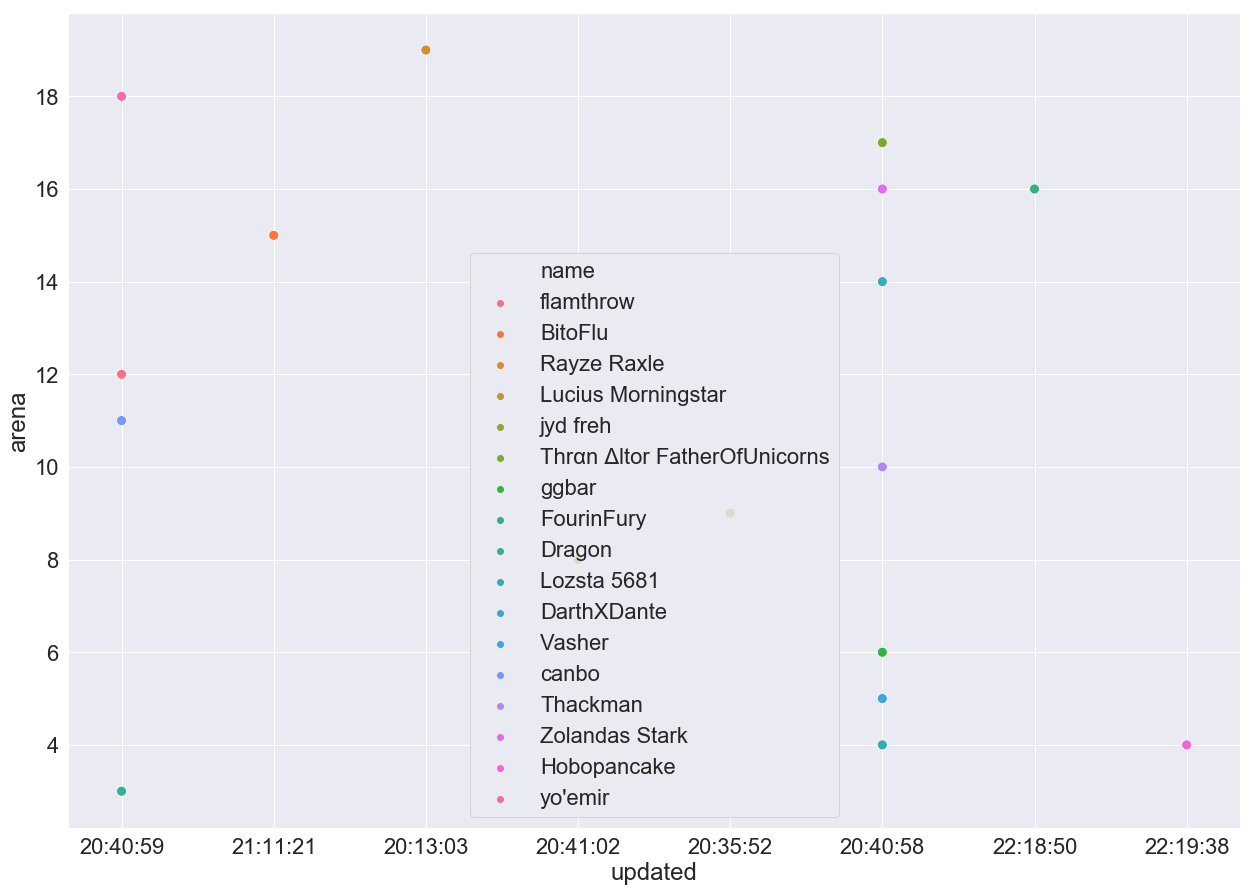

In [50]:
df_co.sort_values('updated')
plt.figure(figsize=(21,15))
sns.set(font_scale=2)
sns.scatterplot(data=df_co[df_co['arena']<20],x=df_co['updated'].dt.strftime('%H:%M:%S'),
                y='arena',hue='name',s=100)

/home/motornyi/.local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


KeyError: "None of [Index(['20:40:58', '20:40:59', '20:40:59', '20:40:59', '20:40:59', '21:11:21',\n       '20:40:58', '20:13:03', '20:41:02', '20:35:52', '20:40:58', '20:40:59',\n       '20:40:58', '20:40:58', '22:18:50', '20:40:59', '20:40:58', '20:40:58',\n       '20:14:03', '20:40:58', '20:40:58', '20:40:58', '20:40:58', '22:19:31',\n       '20:40:58', '20:14:03', '20:40:59', '20:40:58', '20:40:58', '22:19:38',\n       '20:40:58', '20:40:59', '20:40:59'],\n      dtype='object')] are in the [columns]"

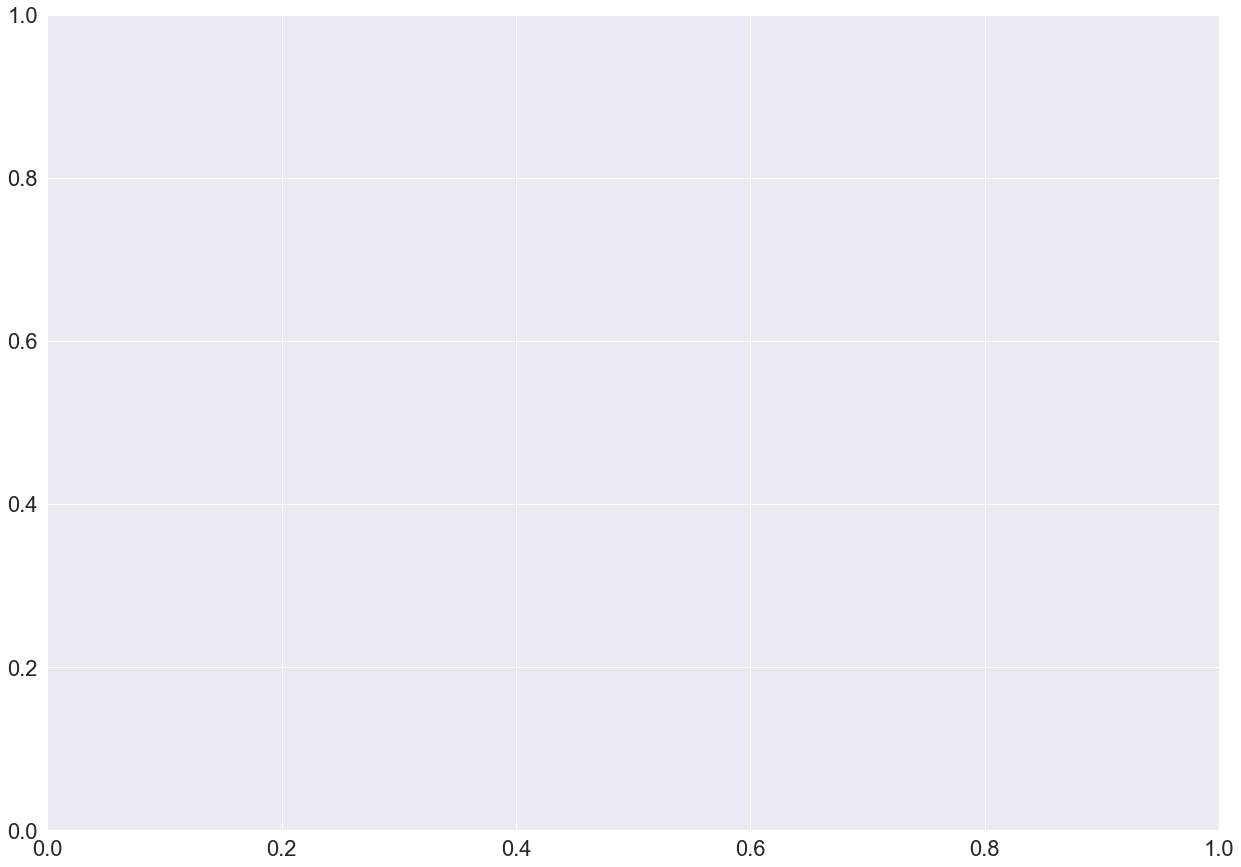

In [53]:
df_co.sort_values('updated')
plt.figure(figsize=(21,15))
sns.set(font_scale=2)
sns.tsplot(data=df_co,time=df_co['updated'].dt.strftime('%H:%M:%S'),
                value='arena',condition='name',s=100)

In [38]:
datetime.strftime()

TypeError: descriptor 'strftime' of 'datetime.date' object needs an argument

In [10]:

one_payer[0]#['roster'][20]

{'allyCode': 928428534,
 'id': 'P143034089',
 'name': 'Lossberg',
 'level': 85,
 'titles': {'selected': 'PLAYERTITLE_LOYAL_FRIEND',
  'unlocked': ['PLAYERTITLE_DARKLORD',
   'PLAYERTITLE_USURPER',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_HANSOLO',
   'PLAYERTITLE_REBELSCUM',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_DARTHTRAYA',
   'PLAYERTITLE_GRANDARENA_INTRO',
   'PLAYERTITLE_CHALLENGER',
   'PLAYERTITLE_PRODIGALKNIGHT',
   'PLAYERTITLE_PITFIGHTER',
   'PLAYERTITLE_SITHSMITER',
   'PLAYERTITLE_SQUADCAPTAIN',
   'PLAYERTITLE_DARKSIDEHISTORIAN',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_GENERALKENOBI',
   'PLAYERTITLE_GENERAL',
   'PLAYERTITLE_HOLOTABLEHERO',
   'PLAYERTITLE_GRANDARENA_ADVANCED',
   'PLAYERTITLE_LOYAL_FRIEND']},
 'guildRefId': 'G2512223038',
 'guildName': 'LØFÂ MÊCQ',
 'guildBannerColor': 'gold_purple',
 'guildBannerLogo': 'guild_icon_havoc',
 'guildTypeId': 'NORMAL',
 'stats': [{'nameKey': 'Galactic Power:', 'value': 3376026, 'index': 1},
  {'nameKey': 'Galactic Power (Characters)

In [7]:
calculate_secondaries(one_payer[0],"UNITSTATSPEED",(1,10))

{1: 423, 10: 195}

In [66]:
def secondaries_table(player,stat,thresh):
    tr_d=dict(zip(thresh,[0]*len(thresh)))
    df_mods=pd.DataFrame(columns=['allyCode','name',"Character","Slot","secondary:"+stat,'tier','rolls',"primary stat"])
    for char in player['roster']:
        for mod in char['mods']:
            for secondary_stat in mod['secondaryStat']:
                if secondary_stat['unitStat']==stat:
                    df_mods=df_mods.append(dict(zip(df_mods.columns.to_list(),
                                                    [player['allyCode'],player['name'],char['nameKey'],mod['slot'],secondary_stat['value'],
                                                     mod['tier'],secondary_stat['roll'],
                                                     mod['primaryStat']['unitStat']])),ignore_index=True)
                    #for tr_one in thresh:
                    #    if secondary_stat['value']>=tr_one: tr_d[tr_one]+=1
                    #break
    return df_mods 

In [118]:
def all_mods(player,stat,thresh):
    #df_mods=pd.DataFrame(columns=['modId','allyCode','name',"Character","Slot","primary stat",'Tier'])
    row_list=[]
    for char in player['roster']:
        for mod in char['mods']:
            mod_dic=OrderedDict()
            mod_dic.update({'id':mod['id'],'allyCode':player['allyCode'],'Name':player['name'],"Character":char['nameKey'],
                           "Slot":mod['slot'],'tier':mod['tier'],'primary stat':mod['primaryStat']['unitStat']})
            
            for secondary_stat in mod['secondaryStat']:
                mod_dic.update({secondary_stat['unitStat']:secondary_stat['value']})
            row_list.append(mod_dic)
                #    df_mods=df_mods.append(dict(zip(df_mods.columns.to_list(),
                #                                    [mod['id']player['allyCode'],player['name'],char['nameKey'],mod['slot'],secondary_stat['value'],
                #                                     mod['tier'],secondary_stat['roll'],
                #                                     mod['primaryStat']['unitStat']])),ignore_index=True)
                    #for tr_one in thresh:
                    #    if secondary_stat['value']>=tr_one: tr_d[tr_one]+=1
                    #break
   # return row_list
    return pd.DataFrame.from_dict(row_list) 

In [ ]:
all_my_mods=all_mods(one_payer[0],"UNITSTATSPEED",(1,10))

In [ ]:
all_my_mods

In [109]:
all_my_mods.set_index(["Name","Character"]).sort_index().to_excel("my_mods.xlsx")
all_my_mods.set_index(["Name","Character"]).sort_index().to_csv('my_mods.csv')

In [75]:
test_df=pd.DataFrame(columns=["Slot",'stat','tier','rolls','id'])
test_df.set_index('id',inplace=True)

In [87]:
rows_list=[]
mod_dic={}
mod_dic.update({"Slot":1,"stat":2,"tier":"gold",'rolls':4,'id':30,"bla1":1})
rows_list.append(mod_dic)
mod_dic={}
mod_dic.update({"Slot":3,"stat":2,"tier":"gold",'rolls':4,'id':30})
rows_list.append(mod_dic)
mod_dic={}
mod_dic.update({"Slot":3,"stat":2,"tier":"gold",'rolls':4,'id':30,"bla":0})
rows_list.append(mod_dic)
pd.DataFrame(rows_list)               

,Slot,bla,bla1,id,rolls,stat,tier
0,1,NaN,1.0,30,4,2,gold
1,3,NaN,NaN,30,4,2,gold
2,3,0.0,NaN,30,4,2,gold


In [89]:
mod_dic={}
mod_dic.update({"Slot":1,"stat":2,"tier":"gold",'rolls':4,'id':30,"bla1":1})
mod_dic.update({'ine mire':1})
mod_dic

{'Slot': 1,
 'stat': 2,
 'tier': 'gold',
 'rolls': 4,
 'id': 30,
 'bla1': 1,
 'ine mire': 1}

In [74]:
test_df=test_df.append({"Slot":1,"stat":2,"tier":"gold",'rolls':4,'id':30})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [73]:
test_df

,Slot,stat,tier,rolls
0,1,2,gold,4


In [32]:
dict(zip(test_df.columns.to_list(),[1,2,'bla,',3]))

{'Slot': 1, 'stat': 2, 'tier': 'bla,', 'rolls': 3}

In [62]:
mods_p=secondaries_table(one_payer[0],"UNITSTATSPEED",(1,10))

In [ ]:
mods_p.to

In [65]:
mods_p.set_index(["name","Character"]).sort_index().to_excel("my_mods.xlsx")

In [52]:
one_payer[0]

{'allyCode': 928428534,
 'id': 'P143034089',
 'name': 'Lossberg',
 'level': 85,
 'titles': {'selected': 'PLAYERTITLE_LOYAL_FRIEND',
  'unlocked': ['PLAYERTITLE_DARKLORD',
   'PLAYERTITLE_USURPER',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_HANSOLO',
   'PLAYERTITLE_REBELSCUM',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_DARTHTRAYA',
   'PLAYERTITLE_GRANDARENA_INTRO',
   'PLAYERTITLE_CHALLENGER',
   'PLAYERTITLE_PRODIGALKNIGHT',
   'PLAYERTITLE_PITFIGHTER',
   'PLAYERTITLE_SITHSMITER',
   'PLAYERTITLE_SQUADCAPTAIN',
   'PLAYERTITLE_DARKSIDEHISTORIAN',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_GENERALKENOBI',
   'PLAYERTITLE_GENERAL',
   'PLAYERTITLE_HOLOTABLEHERO',
   'PLAYERTITLE_GRANDARENA_ADVANCED',
   'PLAYERTITLE_LOYAL_FRIEND']},
 'guildRefId': 'G2512223038',
 'guildName': 'LØFÂ MÊCQ',
 'guildBannerColor': 'gold_purple',
 'guildBannerLogo': 'guild_icon_havoc',
 'guildTypeId': 'NORMAL',
 'stats': [{'nameKey': 'Galactic Power:', 'value': 3376002, 'index': 1},
  {'nameKey': 'Galactic Power (Characters)

In [9]:
codes=[475677623,443477325,733412975,243562266,335172946,59811669,585869154,464589842,849453774,629767947,381165672,851234393,611165496]

In [10]:
guild=get_guild_full(CONFIG, codes)

{'token_type': 'bearer', 'access_token': '5f96fb71035ecaad2fc01193fea6b40852485363', 'expires_in': 3600}
Logged in successfully


In [11]:
df=pd.DataFrame(data=guild[0]['roster'])

In [13]:
df=pd.DataFrame()
for g in guild:
    df=pd.concat([df,pd.DataFrame(data=g['roster'])])
df.set_index("allyCode",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 225995516 to 786762861
Data columns (total 8 columns):
gp                  594 non-null int64
gpChar              594 non-null int64
gpShip              594 non-null int64
guildMemberLevel    594 non-null int64
id                  594 non-null object
level               594 non-null int64
name                594 non-null object
updated             594 non-null int64
dtypes: int64(6), object(2)
memory usage: 41.8+ KB


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 225995516 to 786762861
Data columns (total 8 columns):
gp                  594 non-null int64
gpChar              594 non-null int64
gpShip              594 non-null int64
guildMemberLevel    594 non-null int64
id                  594 non-null object
level               594 non-null int64
name                594 non-null object
updated             594 non-null int64
dtypes: int64(6), object(2)
memory usage: 41.8+ KB


In [16]:
df

,gp,gpChar,gpShip,guildMemberLevel,id,level,name,updated
allyCode,,,,,,,,
225995516,4552844,2741690,1811154,2,P3765115380,85,Graxus,1559667794255
583633697,4636095,2782224,1853871,2,P2606968611,85,Ying,1559667794595
322493497,4292015,2597231,1694784,2,P1994421883,85,Osiris,1559667798091
983137982,5020433,3011521,2008912,3,P3409989264,85,Maim Voorhees,1559667793854
786171649,5071988,3016193,2055795,2,P2892188754,85,Tazz,1559667794250
979741453,4535840,2768757,1767083,2,P2511757705,85,OrionCall,1559667793805
681219214,4075628,2457032,1630070,3,P2260894015,85,Cloudxmt,1559667793680
327122325,4299742,2581688,1718054,2,P4109338348,85,Parabola,1559667722890
975965452,4569807,2809210,1760597,2,P682602420,85,Leal Chan,1559667794959


In [16]:
df['gpChar'] = df['gpChar']/10**6
df['gpShip'] = df['gpShip']/10**6
df['gp'] = df['gp']/10**6

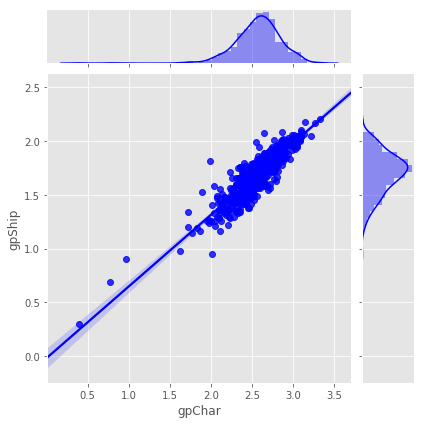

In [17]:
sns.jointplot(data=df,x="gpChar",y="gpShip",kind='reg',color="blue")

In [18]:
#project= {'language': 'eng_us','allycodes': 928428534,'structure':False,
 #         'project':{'roster':
  #                   {'defId':1,'nameKey':1,'gear':1,'gp':1,'level':1,'rarity':1,"combatType":1}}}
#one_player=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
#one_player

In [17]:
#df_player=pd.DataFrame(one_player[0]['roster'])
#df_player.drop(["equipped",'skills','xp','combatType','crew','mods','id','skills'],axis=1,inplace=True)
#df_player.info()

In [18]:
#project= {'language': 'eng_us','allycodes':df.reset_index().iloc[1]["allyCode"].tolist(),'structure':True}
#api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

In [19]:
#project= {'language': 'eng_us','allycodes':df.reset_index().iloc[1]["allyCode"].tolist(),
#          'project':{"allyCode":1,'arena':1,'name':1,'guildRefId':1}}
#p=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

In [20]:
project= {'language': 'eng_us','allycodes':df.reset_index().iloc[1]["allyCode"].tolist(),
          'project':{"allyCode":1,'arena':1,'name':1}}
api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

{'token_type': 'bearer', 'access_token': '6f10b34c483d02152835db9bd4f6095fb5032011', 'expires_in': 3600}
Logged in successfully


[{'allyCode': 231839996,
  'name': 'TheLegend24',
  'arena': {'char': {'rank': 23,
    'squad': [{'id': 'K__iLP9rRFqt3YTbJLgpWQ',
      'defId': 'DARTHREVAN',
      'squadUnitType': 2},
     {'id': 'wnWpW4QDTBuu8Qk_yZ_3dg', 'defId': 'HK47', 'squadUnitType': 1},
     {'id': 'm3Gs-2RCSHaIFniOenQmPA',
      'defId': 'BASTILASHANDARK',
      'squadUnitType': 1},
     {'id': 'nadvBf7TT2ercI7G_m4UPg',
      'defId': 'DARTHMALAK',
      'squadUnitType': 1},
     {'id': '34MjCPbQSdaMNwBjiq_Fgw',
      'defId': 'SITHTROOPER',
      'squadUnitType': 1}]},
   'ship': {'rank': 59,
    'squad': [{'id': 'UDbEokFOSgmyxKTSG1jlPg',
      'defId': 'CAPITALMONCALAMARICRUISER',
      'squadUnitType': 3},
     {'id': 'O3byqm63SeiEgTBjC3IO_A',
      'defId': 'HOUNDSTOOTH',
      'squadUnitType': 1},
     {'id': 'M-ux_fInQD2Fw6-VgHzgCg',
      'defId': 'MILLENNIUMFALCON',
      'squadUnitType': 1},
     {'id': 'KNfGks_hRKib6VuUWUTJMQ',
      'defId': 'XWINGRED3',
      'squadUnitType': 1},
     {'id': '_1RWU

In [19]:
project= {'language': 'eng_us','allycodes':df.reset_index()["allyCode"].tolist(),'project':
          {'arena':1,'name':1,"allyCode":1,'guildRefId':1,"guildName":1,'roster':
           {'defId':1,'gear':1,'gp':1,"combatType":1}}}
players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
#project= {'language': 'eng_us', 'enums':True,'allycodes':df.iloc[0:10].reset_index()["allyCode"].tolist(),'project':
##          {'arena':1,'name':1,"allyCode":1,'guildRefId':1,"guildName":1,'roster':
 #          {'defId':1,'gear':1,'gp':1,"combatType":1,'mods':1}}}
#players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

{'token_type': 'bearer', 'access_token': '1ac98910baab5cf1a7efde7c4ce7275b16410863', 'expires_in': 3600}
Logged in successfully


In [20]:
stat_thr=(1,15)
for player in players:
    df_player=pd.DataFrame(player['roster'])
    df.loc[player['allyCode'],'gp11+']=df_player[
        (df_player['combatType']==1) & (df_player['gear']>=11)
    ]["gp"].sum()/10**6/df.loc[player['allyCode'],'gpChar']
    df.loc[player['allyCode'],'arena']=player['arena']['char']['rank']
    df.loc[player['allyCode'],'guildId']=player['guildRefId']
    df.loc[player['allyCode'],'guildName']=player['guildName']
    #mod_sum=calculate_secondaries(player,"UNITSTATSPEED",stat_thr)
    #for thr in stat_thr:
    #    df.loc[player['allyCode'],"mod"+str(thr)]=mod_sum[thr]

In [27]:
project= {'language': 'eng_us', 'enums':True,'allycodes':df.iloc[0:25].reset_index()["allyCode"].tolist(),'project':
          {"allyCode":1,'roster':
           {'mods':1}}}
players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
len(players)

{'token_type': 'bearer', 'access_token': '705f8414eb00751b8f5983fcdc580aedf36c7821', 'expires_in': 3600}
Logged in successfully


25

In [2]:
len(df[590:610])

NameError: name 'df' is not defined

In [43]:
stat_thr=(1,15)
for i in range(540,len(df),15):#len(df)
    project= {'language': 'eng_us', 'enums':True,'allycodes':df.iloc[i:i+15].reset_index()["allyCode"].tolist(),'project':
              {"allyCode":1,'roster':
               {'mods':1}}}
    players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
    for player in players:
        mod_sum=calculate_secondaries(player,"UNITSTATSPEED",stat_thr)
        for thr in stat_thr:
            df.loc[player['allyCode'],"mod"+str(thr)]=mod_sum[thr]
    print(len(players))
    print(i)
    

{'token_type': 'bearer', 'access_token': 'ed3580ee7481d5d4b925906f83a3ee432be3666d', 'expires_in': 3600}
Logged in successfully


15
540


{'token_type': 'bearer', 'access_token': 'c8a58eb245d73ee826b49c90d1826194ab560a5c', 'expires_in': 3600}
Logged in successfully


15
555


{'token_type': 'bearer', 'access_token': 'e5d82689a9f6f0c8e77194bd43969b444364f8d3', 'expires_in': 3600}
Logged in successfully


15
570


{'token_type': 'bearer', 'access_token': '2fb08d8b864f2bb34989feb376a21f680cf252b5', 'expires_in': 3600}
Logged in successfully


7
585


In [90]:
df.tail()

,gp,gpChar,gpShip,guildMemberLevel,id,level,name,updated,gp11+,arena,guildId,guildName,mod1,mod15
allyCode,,,,,,,,,,,,,,
161612449,4.522307,2.720999,1.803906,2,P4164987073,85,Sty,1559596347063,0.674583,3.0,G3277142610,Ewokin Dead,460.0,54.0
293633393,4.419398,2.664658,1.754740,2,P592970439,85,Wasabi,1559596417751,0.724345,23.0,G3277142610,Ewokin Dead,599.0,68.0
279475463,4.947897,2.991299,1.956598,2,P465912789,85,GeneralHawk,1559596417180,0.820533,7.0,G3277142610,Ewokin Dead,695.0,122.0
917792978,4.614058,2.741986,1.872072,2,P2006374775,85,Ituralde,1559596417727,0.642987,44.0,G3277142610,Ewokin Dead,557.0,40.0
247898257,3.640309,2.303277,1.337032,2,P1071095632,85,Loganwolverine8,1559596418441,0.514770,20.0,G3277142610,Ewokin Dead,379.0,43.0


In [94]:
stat_thr=(1,10,15,20,25)
for i in range(0,len(df),20):#len(df)
    project= {'language': 'eng_us', 'enums':True,'allycodes':df.iloc[i:i+20].reset_index()["allyCode"].tolist(),'project':
              {"allyCode":1,'roster':
               {'mods':1}}}
    players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
    for player in players:
        mod_sum=calculate_secondaries(player,"UNITSTATSPEED",stat_thr)
        for thr in stat_thr:
            df.loc[player['allyCode'],"mod"+str(thr)]=mod_sum[thr]
    print(len(players))
    print(i)
    time.sleep(1.5)

{'token_type': 'bearer', 'access_token': '6bb427973c5e85c16b1355a93085d5cb05f1353d', 'expires_in': 3600}
Logged in successfully


20
0


{'token_type': 'bearer', 'access_token': '38b53ba36add749acf42c3b6e52af8981d064997', 'expires_in': 3600}
Logged in successfully


16
20


{'token_type': 'bearer', 'access_token': 'ae8000ffe79119dacb16629eafbf7d276ce67a60', 'expires_in': 3600}
Logged in successfully


20
40


{'token_type': 'bearer', 'access_token': '5987631347a545ae2f8fd3f8288f88fd885b2101', 'expires_in': 3600}
Logged in successfully


20
60


{'token_type': 'bearer', 'access_token': '1a0418c4085d15521e2455fb63288f808ef7ab71', 'expires_in': 3600}
Logged in successfully


20
80


{'token_type': 'bearer', 'access_token': 'a82de8ab27d2bfff8a8f072526daf9fcc7af8dd7', 'expires_in': 3600}
Logged in successfully


20
100


{'token_type': 'bearer', 'access_token': 'c3365cc8cdf72772d76012dd506c1859ccdaff59', 'expires_in': 3600}
Logged in successfully


20
120


{'token_type': 'bearer', 'access_token': '59dbf8de53fcae89cba6bcfc06732b302f0f18c7', 'expires_in': 3600}
Logged in successfully


20
140


{'token_type': 'bearer', 'access_token': 'dbcdec343a7ed6f04c27b26c58241690c9dcaaaa', 'expires_in': 3600}
Logged in successfully


20
160


{'token_type': 'bearer', 'access_token': '24fe9532df2bbb54d93cee3af95d03bfb0095016', 'expires_in': 3600}
Logged in successfully


20
180


{'token_type': 'bearer', 'access_token': '140f9879e808ab64dbfb5c506a1819c2bff7a278', 'expires_in': 3600}
Logged in successfully


20
200


{'token_type': 'bearer', 'access_token': '1402bc516ffe4f8ea4cab009043a2c8c98869ce4', 'expires_in': 3600}
Logged in successfully


20
220


{'token_type': 'bearer', 'access_token': '0c0ed309aac4750f589a6a620c3c6777e446b0ff', 'expires_in': 3600}
Logged in successfully


20
240


{'token_type': 'bearer', 'access_token': '5d3f6b26ce1064e0ff3c47fb8d36e06b83532310', 'expires_in': 3600}
Logged in successfully


20
260


{'token_type': 'bearer', 'access_token': '6634db52bac08d9cae726202925cd1ecea9d11e2', 'expires_in': 3600}
Logged in successfully


20
280


{'token_type': 'bearer', 'access_token': '161ea81402acdb96651c377a1f0e7c5941d989f0', 'expires_in': 3600}
Logged in successfully


20
300


{'token_type': 'bearer', 'access_token': 'e152bedfc1cdbc76d4a9958a2df62545eef5e4a5', 'expires_in': 3600}
Logged in successfully


20
320


{'token_type': 'bearer', 'access_token': '780ea3dc077f2d03f89488b49f0a48e59c527abb', 'expires_in': 3600}
Logged in successfully


20
340


{'token_type': 'bearer', 'access_token': 'c75dcfa9a7e6b47a3cd91666b64f9b5a2b5893c5', 'expires_in': 3600}
Logged in successfully


20
360


{'token_type': 'bearer', 'access_token': '666c9860eb4f6c43f2d840cc06b22b189d5f3420', 'expires_in': 3600}
Logged in successfully


20
380


{'token_type': 'bearer', 'access_token': 'c9b9fcd816a4d7f83af91d33c5609b91d2d35d96', 'expires_in': 3600}
Logged in successfully


20
400


{'token_type': 'bearer', 'access_token': '48c9db2ab2a06715a79df16ab9cd0691d2e8f0ce', 'expires_in': 3600}
Logged in successfully


20
420


{'token_type': 'bearer', 'access_token': '57b02923e89f54bdfba9ce941e4635436e90c557', 'expires_in': 3600}
Logged in successfully


20
440


{'token_type': 'bearer', 'access_token': 'f1c61b571f1b3ef33073ac2a90753f8def2cb321', 'expires_in': 3600}
Logged in successfully


20
460


{'token_type': 'bearer', 'access_token': '9bf5ece38f194fc1449d37c1abf920c3330c269f', 'expires_in': 3600}
Logged in successfully


20
480


{'token_type': 'bearer', 'access_token': '6352af106679bdd8147f1ffb4d5b21854859532e', 'expires_in': 3600}
Logged in successfully


20
500


{'token_type': 'bearer', 'access_token': '090c5af2a545b41d1738fee3ab61a31246613592', 'expires_in': 3600}
Logged in successfully


20
520


{'token_type': 'bearer', 'access_token': '2cd83c2a9357b6605933580d02b568a9da638195', 'expires_in': 3600}
Logged in successfully


20
540


{'token_type': 'bearer', 'access_token': 'a032fa498312eae7915f696f52e8575cfed2bc8b', 'expires_in': 3600}
Logged in successfully


20
560


{'token_type': 'bearer', 'access_token': '9d7539bd891af850542c61c72ba5bbdf0ee384aa', 'expires_in': 3600}
Logged in successfully


12
580


In [58]:
    project= {'language': 'eng_us', 'enums':True,'allycodes':df.iloc[0:1].reset_index()["allyCode"].tolist(),'project':
              {"allyCode":1,'roster':
               {'mods':1}}}
    players=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)
    print(len(players))

3


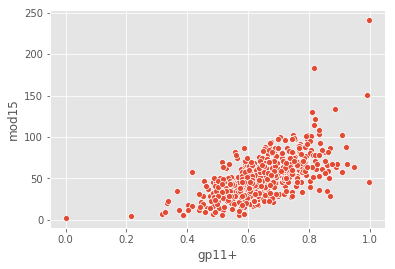

In [106]:
sns.scatterplot(data=df[df['arena']<1000],x='gp11+',y='mod15')

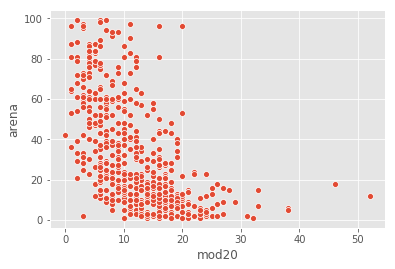

In [140]:
sns.scatterplot(data=df[df['arena']<100],x='mod20',y='arena')

In [145]:
df.fillna(0,inplace=True)

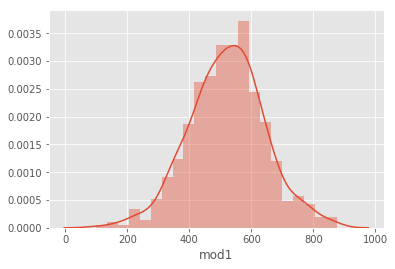

In [150]:
sns.distplot(df['mod1'],kde=True,norm_hist=False)

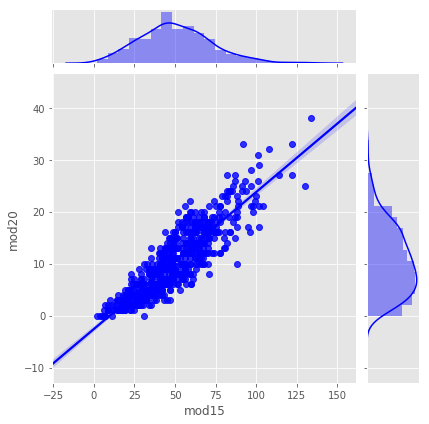

In [133]:
sns.jointplot(data=df[df['mod15']<150],x="mod15",y="mod20",kind='reg',color='blue')

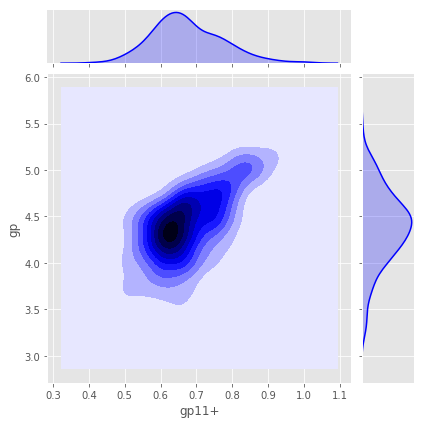

In [45]:
sns.jointplot(data=df[df['arena']<50],x="gp11+",y="gp",kind='kde',color='blue')

In [91]:
df.to_csv('guild_players_mods.csv')

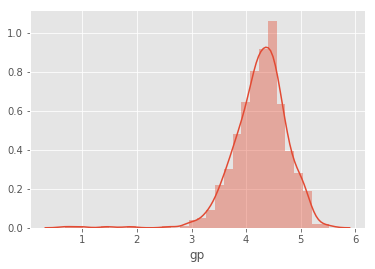

In [20]:
sns.distplot(df['gp'],bins=30)

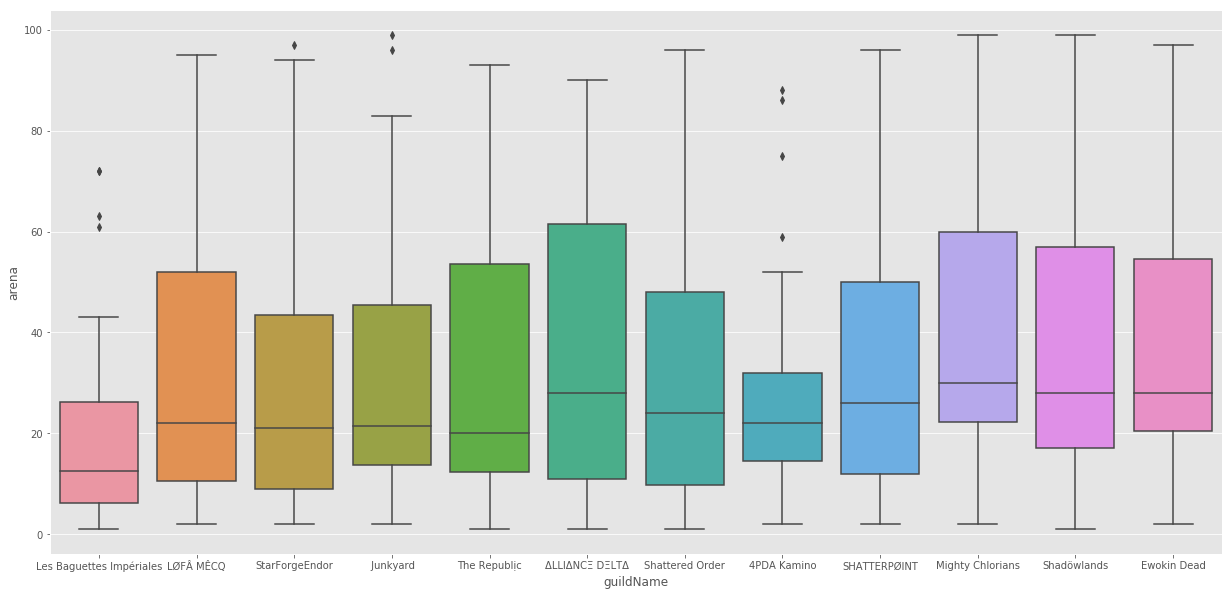

In [111]:
plt.figure(figsize=(21,10))
sns.boxplot(y='arena',x='guildName',data=df[df['arena']<100])

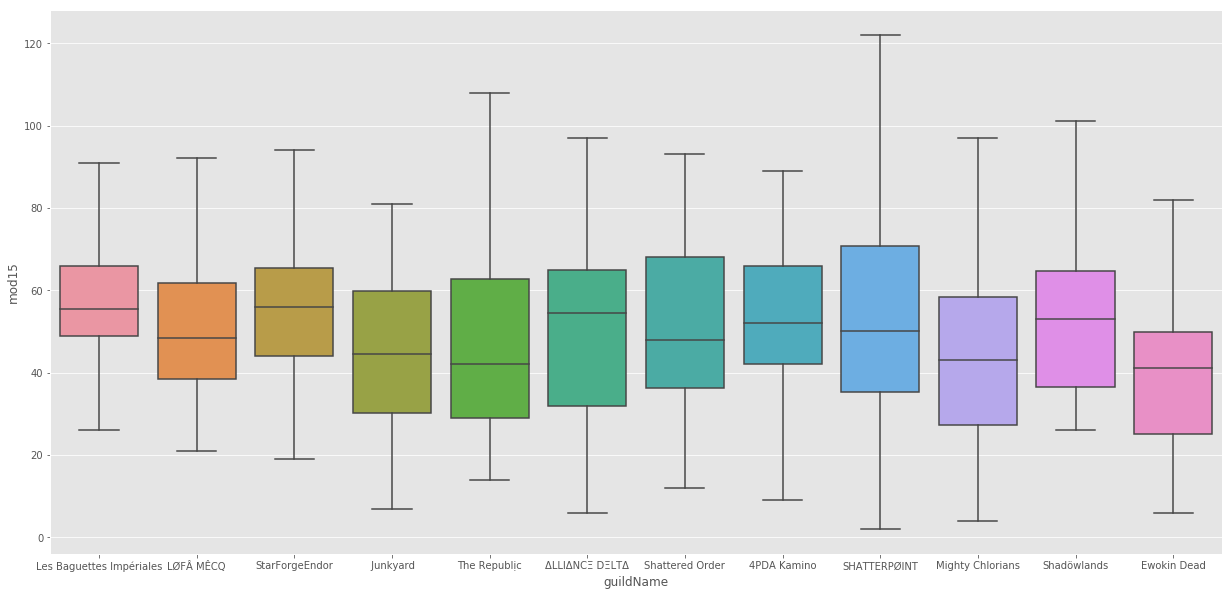

In [125]:
plt.figure(figsize=(21,10))
sns.boxplot(y='mod15',x='guildName',data=df[df['arena']<10000],sym='')

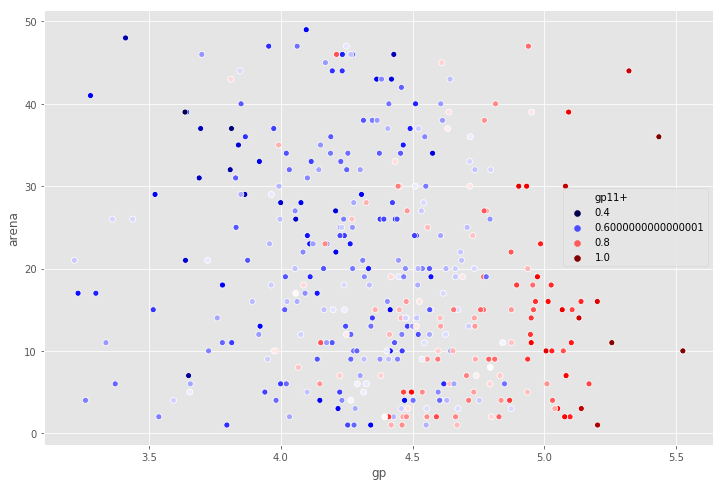

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df[(df['gp']>2) & (df['arena'] < 50)],x="gp",y="arena",hue="gp11+",palette="seismic")

In [23]:
df.corr()

,gp,gpChar,gpShip,guildMemberLevel,level,updated,gp11+,arena
gp,1.000000,0.981979,0.966201,0.071806,NaN,-0.006922,0.689399,-0.523585
gpChar,0.981979,1.000000,0.900087,0.067476,NaN,-0.006315,0.698713,-0.525204
gpShip,0.966201,0.900087,1.000000,0.073942,NaN,-0.007056,0.636857,-0.491353
guildMemberLevel,0.071806,0.067476,0.073942,1.000000,NaN,-0.073613,0.074727,-0.109430
level,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
updated,-0.006922,-0.006315,-0.007056,-0.073613,NaN,1.000000,-0.054488,0.076467
gp11+,0.689399,0.698713,0.636857,0.074727,NaN,-0.054488,1.000000,-0.461445
arena,-0.523585,-0.525204,-0.491353,-0.109430,NaN,0.076467,-0.461445,1.000000


In [24]:
df.sort_values(by='gp11+',axis=0,ascending=False)[['name','gp','gpChar','gp11+']].head()
#df.sort_values(by='gp11+',axis=0,ascending=False)[['name','gp','gpChar','gp11+']].to_excel('gp11plus.xlsx')

,name,gp,gpChar,gp11+
allyCode,,,,
851234393,Toda Kana,5.525704,3.320501,0.999608
629767947,DocDC,5.434581,3.271992,0.999608
475677623,Postman,5.256053,3.212756,0.991451
849453774,SF Crixus,5.201882,3.137158,0.948514
721945231,Ico,5.080210,3.085754,0.925490


In [25]:
project= {'language': 'eng_us','allycodes':{928428534,'enums':True}
one_payer=api_call(CONFIG, project, '%s/swgoh/players' % SWGOH_HELP)

{'token_type': 'bearer', 'access_token': '6425e246fdc80b44021dd05fef9623c5b337bb4f', 'expires_in': 3600}
Logged in successfully


In [26]:
one_payer

[{'allyCode': 928428534,
  'id': 'P143034089',
  'name': 'Lossberg',
  'level': 85,
  'titles': {'selected': 'PLAYERTITLE_USURPER',
   'unlocked': ['PLAYERTITLE_DARKLORD',
    'PLAYERTITLE_USURPER',
    'PLAYERTITLE_GRANDARENA_CHALLENGE_HANSOLO',
    'PLAYERTITLE_REBELSCUM',
    'PLAYERTITLE_GRANDARENA_CHALLENGE_DARTHTRAYA',
    'PLAYERTITLE_GRANDARENA_INTRO',
    'PLAYERTITLE_CHALLENGER',
    'PLAYERTITLE_PRODIGALKNIGHT',
    'PLAYERTITLE_PITFIGHTER',
    'PLAYERTITLE_SITHSMITER',
    'PLAYERTITLE_SQUADCAPTAIN',
    'PLAYERTITLE_DARKSIDEHISTORIAN',
    'PLAYERTITLE_GRANDARENA_CHALLENGE_GENERALKENOBI',
    'PLAYERTITLE_GENERAL',
    'PLAYERTITLE_HOLOTABLEHERO',
    'PLAYERTITLE_GRANDARENA_ADVANCED',
    'PLAYERTITLE_LOYAL_FRIEND']},
  'guildRefId': 'G2512223038',
  'guildName': 'LØFÂ MÊCQ',
  'guildBannerColor': 'gold_purple',
  'guildBannerLogo': 'guild_icon_havoc',
  'guildTypeId': 'NORMAL',
  'stats': [{'nameKey': 'Galactic Power:', 'value': 3360746, 'index': 1},
   {'nameKey': 'Gal

In [44]:
def gen_dict_extract(key, var):
    if hasattr(var,'iteritems'):
        for k, v in var.iteritems():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in gen_dict_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_dict_extract(key, d):
                        yield result

In [57]:
def findkeys(node, kv):
    if isinstance(node, list):
        for i in node:
            for x in findkeys(i, kv):
               yield x
    elif isinstance(node, dict):
        if kv in node:
            yield node[kv]
        for j in node.values():
            for x in findkeys(j, kv):
                yield x

In [58]:
def search(d,search_pattern,prev_datapoint_path=[]):
    output = []
    current_datapoint = d
    current_datapoint_path = prev_datapoint_path.copy()
    if type(current_datapoint) is dict:
        for dkey in current_datapoint:
            if search_pattern in str(dkey):
                c = current_datapoint_path.copy()
                c.append(dkey)
                output.append(c)
            c = current_datapoint_path.copy()
            c.append(dkey)
            output.append(search(current_datapoint[dkey],search_pattern,c))
    elif type(current_datapoint) is list:
        for i in range(0,len(current_datapoint)):
            if search_pattern in str(i):
                output.append(current_datapoint_path.append(i))
            c= current_datapoint_path.copy()
            c.append(i)
            output.append(search(current_datapoint[i],search_pattern,c))
    elif search_pattern in str(current_datapoint):
        c = current_datapoint_path.copy()
        c.append(current_datapoint)
        output.append(c)
    output = filter(None, output)
    return list(output)

In [59]:
r=findkeys(one_payer,"UNITSTATSPEED")
for i in r:
    print(i)

In [71]:
sr=search(one_payer,"UNITSTATSPEED")

In [187]:
def calculate_secondaries(players,stat,thresh):
    s20=0
    tr_d=dict(zip(tr,[0]*len(tr)))
    for p in players:
        for char in p['roster']:
            for mods in char['mods']:
          #      print(mods['secondaryStat'])
          #      for mod in mods:
                    for i in mods['secondaryStat']:
                            if i['unitStat']==stat:
                                #print(i['value']," rolls ",i['roll'])
                                if i['value']>=10: s20+=1
                                for tr_one in tr:
                                    if i['value']>=tr_one: tr_d[tr_one]+=1
                                break
    return tr_d    

In [191]:
def calculate_secondaries(players,stat,thresh):
    s20=0
    tr_d=dict(zip(tr,[0]*len(tr)))
    #for p in players:
    for char in p['roster']:
        for mods in char['mods']:
      #      print(mods['secondaryStat'])
      #      for mod in mods:
                for i in mods['secondaryStat']:
                        if i['unitStat']==stat:
                            #print(i['value']," rolls ",i['roll'])
                            if i['value']>=10: s20+=1
                            for tr_one in tr:
                                if i['value']>=tr_one: tr_d[tr_one]+=1
                            break
    return tr_d    

In [188]:
calculate_secondaries(one_payer,"UNITSTATSPEED",(10,15,20,25))

{10: 191, 15: 51, 20: 6, 25: 0}

In [198]:
calculate_secondaries(one_payer[0],"UNITSTATSPEED",(10,15,20,25))

{10: 191, 15: 51, 20: 6, 25: 0}

In [125]:
tr=(10,15,20,25)
[0]*len(tr)
tr_d=dict(zip(tr,[0]*len(tr)))

In [128]:
s20=0
tr=(10,15,20,25)
[0]*len(tr)
tr_d=dict(zip(tr,[0]*len(tr)))
for p in one_payer:
    for char in p['roster']:
        for mods in char['mods']:
      #      print(mods['secondaryStat'])
      #      for mod in mods:
                for i in mods['secondaryStat']:
                        if i['unitStat']=='UNITSTATSPEED':
                            #print(i['value']," rolls ",i['roll'])
                            if i['value']>=10: s20+=1
                            for tr_one in tr:
                                if i['value']>=tr_one: tr_d[tr_one]+=1
                            break
print(s20)
print(tr_d)

191
{10: 191, 15: 51, 20: 6, 25: 0}


In [94]:
one_payer[0]

{'allyCode': 928428534,
 'id': 'P143034089',
 'name': 'Lossberg',
 'level': 85,
 'titles': {'selected': 'PLAYERTITLE_USURPER',
  'unlocked': ['PLAYERTITLE_DARKLORD',
   'PLAYERTITLE_USURPER',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_HANSOLO',
   'PLAYERTITLE_REBELSCUM',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_DARTHTRAYA',
   'PLAYERTITLE_GRANDARENA_INTRO',
   'PLAYERTITLE_CHALLENGER',
   'PLAYERTITLE_PRODIGALKNIGHT',
   'PLAYERTITLE_PITFIGHTER',
   'PLAYERTITLE_SITHSMITER',
   'PLAYERTITLE_SQUADCAPTAIN',
   'PLAYERTITLE_DARKSIDEHISTORIAN',
   'PLAYERTITLE_GRANDARENA_CHALLENGE_GENERALKENOBI',
   'PLAYERTITLE_GENERAL',
   'PLAYERTITLE_HOLOTABLEHERO',
   'PLAYERTITLE_GRANDARENA_ADVANCED',
   'PLAYERTITLE_LOYAL_FRIEND']},
 'guildRefId': 'G2512223038',
 'guildName': 'LØFÂ MÊCQ',
 'guildBannerColor': 'gold_purple',
 'guildBannerLogo': 'guild_icon_havoc',
 'guildTypeId': 'NORMAL',
 'stats': [{'nameKey': 'Galactic Power:', 'value': 3360746, 'index': 1},
  {'nameKey': 'Galactic Power (Characters):', '

In [66]:
one_payer[0][[[
         'roster',
         1,
         'mods',
         1,
         'primaryStat',
         'unitStat',
         'UNITSTATSPEED']]]

TypeError: unhashable type: 'list'

In [69]:
import dictor

In [70]:
dictor.dictor(one_payer,"unitStat")

In [26]:
project= {'language': 'eng_us','collection':'statModSetList','structure':False,'enum':True}
api_call(CONFIG, project, '%s/swgoh/data' % SWGOH_HELP)

{'token_type': 'bearer', 'access_token': 'dc73ab408706a596bf01edd01b164a5a3fde2499', 'expires_in': 3600}
Logged in successfully


[{'id': '1',
  'namekey': 'STATMODSETBONUS_SETBONUSSTAT_MAXHEALTHPERCENTADDITIVE_NAME',
  'icon': 'icon_buff_health',
  'completeBonus': {'abilityIdList': [],
   'stat': {'unitStat': 'UNITSTATMAXHEALTHPERCENTADDITIVE',
    'statValueDecimal': 500,
    'unscaledDecimalValue': 5000000}},
  'maxLevelBonus': {'abilityIdList': [],
   'stat': {'unitStat': 'UNITSTATMAXHEALTHPERCENTADDITIVE',
    'statValueDecimal': 500,
    'unscaledDecimalValue': 5000000}},
  'setCount': 2,
  'updated': 1559169027808},
 {'id': '3',
  'namekey': 'STATMODSETBONUS_SETBONUSSTAT_DEFENSEPERCENTADDITIVE_NAME',
  'icon': 'icon_buff_armor',
  'completeBonus': {'abilityIdList': [],
   'stat': {'unitStat': 'UNITSTATDEFENSEPERCENTADDITIVE',
    'statValueDecimal': 1250,
    'unscaledDecimalValue': 12500000}},
  'maxLevelBonus': {'abilityIdList': [],
   'stat': {'unitStat': 'UNITSTATDEFENSEPERCENTADDITIVE',
    'statValueDecimal': 1250,
    'unscaledDecimalValue': 12500000}},
  'setCount': 2,
  'updated': 1559169027808},

In [ ]:
project= {'language': 'eng_us','allycodes': 928428534,'structure':True,'project':{ 'id':0,'roster':0}}
api_call(CONFIG, project, '%s/swgoh/guilds' % SWGOH_HELP)

In [ ]:
project= {'language': 'eng_us','allycodes': 928428534,'project':{'id':1}}
api_call(CONFIG, project, '%s/swgoh/guilds' % SWGOH_HELP)

In [ ]:
db2='G2512223038'+".db"

In [ ]:
    database = db2
    conn = db_create_connection(database)
    isValid=False

In [ ]:
guild_update_time=user_input_date()

In [ ]:
with conn:
        current_time=players_gp_snapshot (conn)
        
        conn.commit()
        compare_all_guild_gp(conn,guild_update_time,current_time,True)

In [ ]:
all_guild_player=db_query_all_players_id_name(conn)

In [ ]:
all_guild_player
time1_id=db_get_timestamp(conn,guild_update_time)
time1_id
time_now=db_get_timestamp(conn,current_time)

In [ ]:
pl=db_query_gp_date(conn,all_guild_player[0][0],time1_id[1])
pl

In [ ]:
d={"GP characters":[pl[0]],"GP ships":[pl[1]],"Ally Code":[pl[2]],"Name":[pl[3]]}

In [ ]:
df=pd.DataFrame(data=d)

In [ ]:
all_guild_player

In [ ]:
rows_list=[]
for player in all_guild_player:
    #print(player[0])
    pl=db_query_gp_date(conn,player[0],time_now[1])
    #print(pl)
    if (pl==None): continue
    dict1 = {}
    dict1.update({"GP characters":pl[0],"GP ships":pl[1],"Ally Code":pl[2],"Name":pl[3]})
    rows_list.append(dict1)

df = pd.DataFrame(rows_list)

In [ ]:
df_sorted=df.sort_values(by="GP characters")
df_sorted.plot.bar(x="Name",y="GP characters")

In [ ]:
db_get_all_times(conn)

In [ ]:
all_guild_player


In [ ]:
rows_list=[]
pid=1
all_times=db_get_all_times(conn)
for one_time in all_times:
    #print(player[0])
    pl=db_query_gp_date(conn,pid,one_time[0])
 #   print(pl)
    if (pl==None): continue
    dict1 = {}
    dict1.update({"GP characters":pl[0],"GP ships":pl[1],"Date":one_time[1]})
    rows_list.append(dict1)
df_time = pd.DataFrame(rows_list)
#print(df_time)
plt.figure(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.title(all_guild_player[pid-1][1])
plt.plot(df_time["Date"],df_time['GP characters'],linestyle='-',marker='x')

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.scatter(df_time["Date"],df_time['GP characters'])